In [61]:
#first we import all the required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [5]:
#Now we mount our drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [62]:
#Reading the data from the dataset and converting it to a Pandas dataframe
df=pd.read_csv('gdrive/My Drive/Dataset.txt')

In [51]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_category,occurance
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [63]:
#Uploading the file from local drive
#The size of the file is very small so we can easily upload it from the local drive
from google.colab import files
uploaded = files.upload()

Saving Attack_types.txt to Attack_types (2).txt


In [64]:
import io
df_t = pd.read_csv(io.BytesIO(uploaded['Attack_types.txt']))

In [65]:
#Mapping each attribute to an attack type. We have 4 attack types and a normal category
mapped_attack = [x.strip().split() for x in open('Attack_types.txt', 'r')]
mapped_attack = {a:b for (a,b) in mapped_attack}

In [66]:
#Replacing the attack_category from the datafram of Dataset by the types of attacks in the attack_map
df['attack_category'] = df['attack_category'].replace(mapped_attack)

In [67]:
#Visualizing our attack map
mapped_attack

{'apache2': 'dos',
 'attack_category': 'attack_type',
 'back': 'dos',
 'buffer_overflow': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'httptunnel': 'u2r',
 'imap': 'r2l',
 'ipsweep': 'probe',
 'land': 'dos',
 'loadmodule': 'u2r',
 'mailbomb': 'dos',
 'mscan': 'probe',
 'multihop': 'r2l',
 'named': 'r2l',
 'neptune': 'dos',
 'nmap': 'probe',
 'perl': 'u2r',
 'phf': 'r2l',
 'pod': 'dos',
 'portsweep': 'probe',
 'processtable': 'dos',
 'ps': 'u2r',
 'rootkit': 'u2r',
 'saint': 'probe',
 'satan': 'probe',
 'sendmail': 'r2l',
 'smurf': 'dos',
 'snmpgetattack': 'dos',
 'snmpguess': 'r2l',
 'spy': 'r2l',
 'sqlattack': 'u2r',
 'teardrop': 'dos',
 'udpstorm': 'dos',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'worm': 'probe',
 'xlock': 'r2l',
 'xsnoop': 'r2l',
 'xterm': 'u2r'}

In [68]:
#encoding the categorical values from the dataframe and replacing them with dummy numerical values
def cat_encoding(df1, col1):
    return pd.concat([df1.drop(col1, axis=1), pd.get_dummies(df1[col1].values)], axis=1)

In [69]:
#Some of the values in the dataframe are very wide in range. Such as duration, Source bytes and Desination Bytes.
#To concatenate them in a small range, we do the log scalling.
def log_scalling(df1, col1):
    return df1[col1].apply(np.log1p)

In [70]:
#Catagorical Values
cat_list = ['protocol_type', 'service', 'flag']
for col in cat_list:
    df = cat_encoding(df, col)

In [71]:
#Log scalling values
log_list = ['duration', 'src_bytes', 'dst_bytes']
for col in log_list:
    df[col] = log_scalling(df, col)

In [72]:
#dropping the label column because we are about to perform K means clustering which is a form of unsupervised learning.
del df["attack_category"]

In [73]:
df = pd.get_dummies(df)

In [74]:
df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,occurance,icmp,...,nnsp,nntp,ntp_u,other,pm_dump,pop_2,pop_3,printer,private,red_i,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois,OTH,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH
0,0.0,6.198479,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,4.990433,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.0,5.451038,9.006264,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.0,5.298317,6.042633,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [75]:
#import all the required libraries for clustering
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
%matplotlib inline

In [76]:
#Performing K means clustering with default parameters
km = KMeans(n_clusters=5)
km.fit(df)
pred_label = km.predict(df)

In [77]:
pred_label

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [78]:
#Length of the predicted label array 
length=len(pred_label)

In [79]:
#We assign them with labels according to the clusters and save it in a list.
#This list would later be added to the dataframe new_labels column.
list1 = []
for i in range(length):
    if pred_label[i]== 0:
      list1.append('Probe')
    elif pred_label[i]==1:
      list1.append('R2L')
    elif pred_label[i]==2:
      list1.append('DoS')
    elif pred_label[i]==3:
      list1.append('U2R')
    elif pred_label[i]==4:
      list1.append('Normal')

In [80]:
#Add the predicted labels to the dataframe
df['new_label'] = list1

In [81]:
df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,occurance,icmp,...,nntp,ntp_u,other,pm_dump,pop_2,pop_3,printer,private,red_i,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois,OTH,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH,new_label
0,0.0,6.198479,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Probe
1,0.0,4.990433,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Probe
2,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Probe
3,0.0,5.451038,9.006264,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,R2L
4,0.0,5.298317,6.042633,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Normal


In [82]:
#Count of each attack type
count= df['new_label'].value_counts()
count

R2L       37475
Probe     34292
Normal    26554
DoS       23569
U2R        4083
Name: new_label, dtype: int64

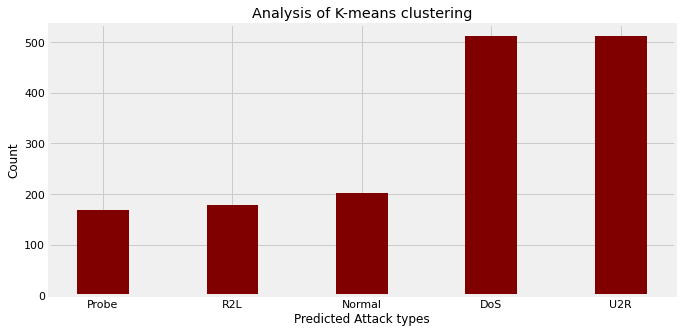

In [84]:
fig = plt.figure(figsize = (10, 5))
plt.bar(df['new_label'], df['count'], color ='maroon', width = 0.4)
plt.xlabel("Predicted Attack types")
plt.ylabel("Count")
plt.title("Analysis of K-means clustering")
plt.show()